# (WIP) 09. PyTorch Model Deployment

Work in progress.

Goal: Take FoodVision Mini model and make it publically accessible (deploy it to a usable app/interface)

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

1.12.0+cu102
0.13.0+cu102


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

Get 20% data to train models on same playing field.

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Train models

Going to train two different feature extractor models:

1. EffNetB2
2. ViT-B/16

### EffNetB2

In [6]:
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

In [7]:
# Setup dataloaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


```
(classifier): Sequential(
    (0): Dropout(p=0.3, inplace=True)
    (1): Linear(in_features=1408, out_features=1000, bias=True)
  )
```

In [8]:
# Create feature extractor model
for param in effnetb2.parameters():
    param.requires_grad=False

# Create the classifier head
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names)))

In [9]:
# summary(effnetb2, 
#         input_size=(1, 3, 224, 224), # try swapping this for "random_input_image_error" 
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [10]:
# Train the model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9856 | train_acc: 0.5604 | test_loss: 0.7408 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7175 | train_acc: 0.8438 | test_loss: 0.5869 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5876 | train_acc: 0.8917 | test_loss: 0.4909 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4474 | train_acc: 0.9062 | test_loss: 0.4355 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4290 | train_acc: 0.9104 | test_loss: 0.3915 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4381 | train_acc: 0.8896 | test_loss: 0.3512 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4245 | train_acc: 0.8771 | test_loss: 0.3268 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3897 | train_acc: 0.8958 | test_loss: 0.3457 | test_acc: 0.9381
Epoch: 9 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3129 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3757 | train_acc: 0.8604 | test_loss: 0.2813 | test_acc: 0.9688


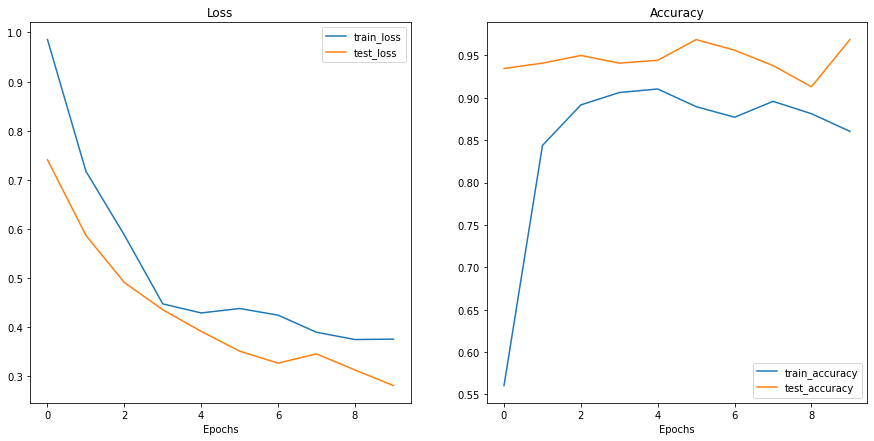

In [11]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [12]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [13]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### ViT feature extractor

Source - https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16

In [14]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = vit_weights.transforms()
vit = torchvision.models.vit_b_16(weights=vit_weights)

# vit_transforms, vit

In [15]:
# Setup dataloaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=vit_transforms,
                                                                                                 batch_size=32)


```
(heads): Sequential(
     (head): Linear(in_features=768, out_features=1000, bias=True)
   )
```

In [16]:
# Create feature extractor model
for param in vit.parameters():
    param.requires_grad=False

# Create the classifier head
set_seeds()
vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=len(class_names)))

In [17]:
# Train the model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


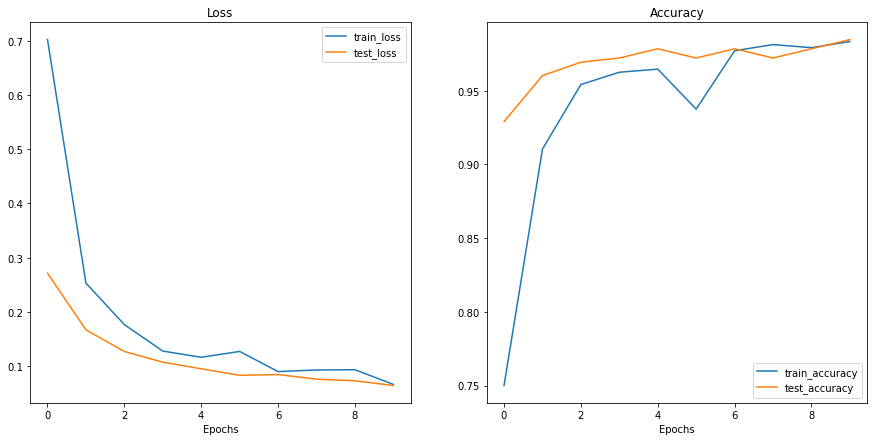

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [19]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [20]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


## TK - Compare model results and sizes 

## TK - Script models

In [21]:
effnetb2_scripted = torch.jit.script(effnetb2)
vit_scripted = torch.jit.script(vit)
# effnetb2_scripted

## TK - Make predictions and time them

In [22]:
# Get all test data paths
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image
from timeit import default_timer as timer 

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
    test_pred_list = []
    for path in tqdm(test_paths):
        # Create empty dict to store info for each sample
        pred_dict = {}

        # Get sample path
        pred_dict["image_path"] = path

        # Get class name
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # Get prediction and prediction probability
        start_time = timer()
        img = Image.open(path) # open image
        transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
        model.to(device)
        model.eval()
        with torch.inference_mode():
            pred_logit = model(transformed_image.to(device))
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]

            # Make sure things in the dictionary are back on the CPU 
            pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
            pred_dict["pred_class"] = pred_class
            
            # Calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # print(pred_dict)
        # Add the dictionary to the list of preds
        test_pred_list.append(pred_dict)

    return test_pred_list

In [23]:
effnetb2_test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                          model=effnetb2_scripted,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

effnetb2_test_pred_dicts[:5]

  0%|          | 0/150 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9293267726898193,
  'pred_class': 'steak',
  'time_for_pred': 0.3122,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9533632397651672,
  'pred_class': 'steak',
  'time_for_pred': 9.6509,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7531499266624451,
  'pred_class': 'steak',
  'time_for_pred': 0.0345,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.59352046251297,
  'pred_class': 'steak',
  'time_for_pred': 0.0329,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8

In [24]:
vit_test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                     model=vit_scripted,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

vit_test_pred_dicts[:5]

  0%|          | 0/150 [00:00<?, ?it/s]

/home/daniel/code/pytorch/env/lib/python3.8/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %556 : int[] = prim::profile_ivalue(%554)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:108.)
  return forward_call(*input, **kwargs)
/home/daniel/code/pytorch/env/lib/python3.8/site-packages/torch/nn/modules/module.py:1130: UserWarning: concrete shape for linear input & weight are required to decompose into matmul + bias (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:2077.)
  return forward_call(*input, **kwargs)


[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/831681.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9932767748832703,
  'pred_class': 'steak',
  'time_for_pred': 0.4457,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3100563.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9893474578857422,
  'pred_class': 'steak',
  'time_for_pred': 18.9816,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2752603.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.997147262096405,
  'pred_class': 'steak',
  'time_for_pred': 0.0611,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7684809565544128,
  'pred_class': 'steak',
  'time_for_pred': 0.0612,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/730464.jpg'),
  'class_name': 'steak',
  'pred_prob': 0

## Most wrong EffNetB2

In [25]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_average_time_per_pred = effnetb2_test_pred_df.time_for_pred.mean()
effnetb2_average_time_per_pred

0.0952913333333333

In [26]:
# Sort DataFrame by correct then by pred_prob 
effnetb2_top_5_most_wrong = effnetb2_test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
effnetb2_top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
77,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.628852,steak,0.0291,False
49,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.580038,sushi,0.0287,False
112,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.529632,sushi,0.0292,False
52,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.519188,sushi,0.0292,False
140,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.397516,steak,0.0288,False


In [27]:
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

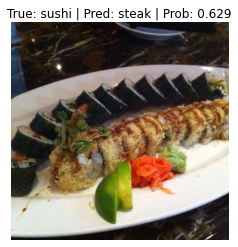

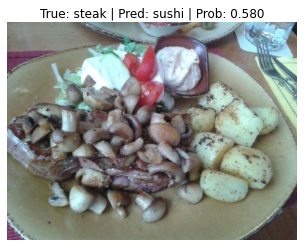

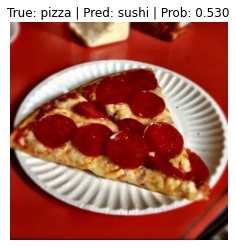

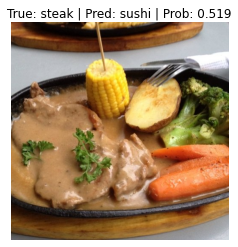

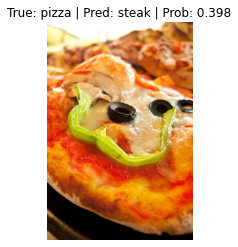

In [28]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in effnetb2_top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]
    # Plot the image and various details
    img = torchvision.io.read_image(str(image_path)) # get image as tensor
    plt.figure()
    plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis(False);

## Most wrong ViT 

In [29]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_average_time_per_pred = vit_test_pred_df.time_for_pred.mean()
vit_average_time_per_pred

0.19094333333333333

In [30]:
# Times for different models
not_scirpted = 0.06972866666666663
scripted = 0.062004 

In [31]:
# Sort DataFrame by correct then by pred_prob 
vit_top_5_most_wrong = vit_test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
vit_top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
52,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.510123,sushi,0.0629,False
71,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.495649,pizza,0.0616,False
126,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.998978,pizza,0.0629,True
110,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.998848,pizza,0.0631,True
138,data/pizza_steak_sushi_20_percent/test/pizza/4...,pizza,0.998832,pizza,0.0620,True


In [32]:
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

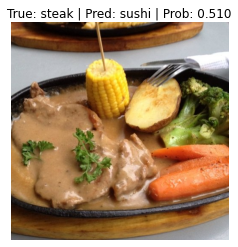

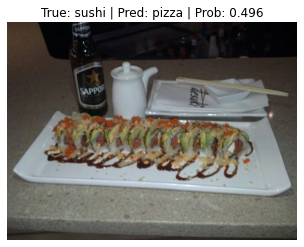

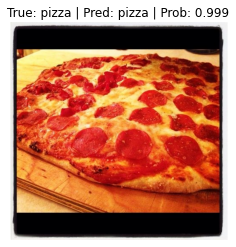

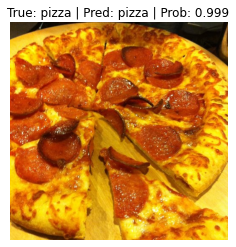

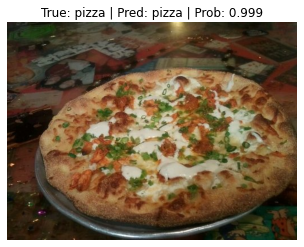

In [33]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in vit_top_5_most_wrong.iterrows():
    row = row[1]
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]
    # Plot the image and various details
    img = torchvision.io.read_image(str(image_path)) # get image as tensor
    plt.figure()
    plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis(False);

## TK - Create a Gradio demo

In [34]:
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr

In [36]:
effnetb2.to("cpu") 

def predict(img):
    img = effnetb2_transforms(image).unsqueeze(0)
    effnetb2.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(effnetb2(img), dim=1)
        pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    return pred_labels_and_probs

import random
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
random_image_path = random.sample(test_data_paths, k=1)[0]
print(random_image_path)
image = Image.open(random_image_path)
predict(img=image)

data/pizza_steak_sushi_20_percent/test/sushi/2274102.jpg


{'pizza': 0.16288381814956665,
 'steak': 0.22118932008743286,
 'sushi': 0.6159268021583557}

In [37]:
gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Label(num_top_classes=3))

Gradio Interface for: predict
-----------------------------
inputs:
|-image
outputs:
|-label

## TK - Try `torch.jit`?

https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html

## TK - Try `ONNX`?